In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from pol.utils.validation.scene_saver import load_scenes, count_h5_keys
from pol.utils.validation.mso_eval import MSOSolution, MSOEvaluation, distance_sqr_matrix
from pol.utils.path import PathHelper

In [2]:
prob = 'conic' # 'prodsin_2d'
path_helper = PathHelper('../../tests/analytical/')

fig_size = 10

if prob == 'prodsin_2d':
    gt_method = 'pd_mlr'
    candidate_methods = ['gol_res_hhlr', 'pol_res_lot']
    obj_thresholds = [-0.99, -0.98, -0.97, -0.96, -0.95]
    precision_thresholds = torch.linspace(0.1, 2.0, 50)
    theta_range = None # [0,1,2,3,4,5,6,7]
    method_itr = {
        # 'pol_res_lot': 5
    }
elif prob == 'conic':
    gt_method = 'pd_mlr'
    candidate_methods = ['pol_res_lot', 'gol_res_mlr']
    obj_thresholds = [0.1, 0.2]
    precision_thresholds = torch.linspace(0.05, 0.4, 50)
    theta_range = None # [0,1,2,3,4,5,6,7]
    method_itr = {
        'pol_mlp_relu_lot_hor10': 5,
        'pol_res_lot_hor10': 5,
        'pol_res_mmot': 5,
        'pol_res_lot': 5,
        'pol_mlp_lot': 5,
        #'gol_res_mlr': 50,
    }
else: 
    assert(False)


In [3]:
def load_solution(method, is_gt):
    scene_path = path_helper.locate_scene_h5(prob, method)
    scene = load_scenes(scene_path)[0]
    if method in method_itr:
        k = method_itr[method]
    else:
        k = count_h5_keys(scene, 'itr') - 1
    tmp = scene['itr_{}'.format(k)]
    print(scene['info']['thetas'][:2])
    X = torch.from_numpy(tmp['X'][:])
    loss = torch.from_numpy(tmp['loss'][:])
    S = torch.from_numpy(tmp['satisfy'][:])
    
    if theta_range is not None:
        X = X[theta_range]
        loss = loss[theta_range]
        S = S[theta_range]
    
    sol = MSOSolution(X=X, F=loss, S=S)
    
    if is_gt:
        witness = torch.from_numpy(scene['info']['witness'][:])
        return sol, witness
    return sol

In [4]:
gt_sol, witness = load_solution(gt_method, is_gt=True)
inf_dist = distance_sqr_matrix(witness, witness).max().sqrt().item()
print(f'inf_dist={inf_dist}')

[[ 0.67749304  0.52402794 -0.47527453  0.5777735  -0.5126657   0.1520035 ]
 [ 0.11664642  0.7022882  -0.80134845  0.6528455   0.1334467  -0.14463821]]
inf_dist=13.967267036437988


Evaluating method pol_res_lot with threshold 0.1 ...
[[ 0.67749304  0.52402794 -0.47527453  0.5777735  -0.5126657   0.1520035 ]
 [ 0.11664642  0.7022882  -0.80134845  0.6528455   0.1334467  -0.14463821]]
{'divergence': tensor(0.0643), 'precision': tensor([0.7143, 0.7456, 0.7750, 0.7980, 0.8164, 0.8302, 0.8433, 0.8541, 0.8642,
        0.8722, 0.8792, 0.8848, 0.8906, 0.8975, 0.9027, 0.9067, 0.9096, 0.9127,
        0.9157, 0.9195, 0.9227, 0.9258, 0.9283, 0.9312, 0.9331, 0.9356, 0.9375,
        0.9393, 0.9412, 0.9429, 0.9449, 0.9469, 0.9486, 0.9502, 0.9519, 0.9531,
        0.9545, 0.9558, 0.9570, 0.9583, 0.9596, 0.9606, 0.9619, 0.9632, 0.9644,
        0.9652, 0.9662, 0.9675, 0.9681, 0.9691]), 'gt_count': tensor(929.2461), 'candidate_count': tensor(965.0312)}
Evaluating method gol_res_mlr with threshold 0.1 ...
[[ 0.67749304  0.52402794 -0.47527453  0.5777735  -0.5126657   0.1520035 ]
 [ 0.11664642  0.7022882  -0.80134845  0.6528455   0.1334467  -0.14463821]]
{'divergence': tensor(0.1070), 

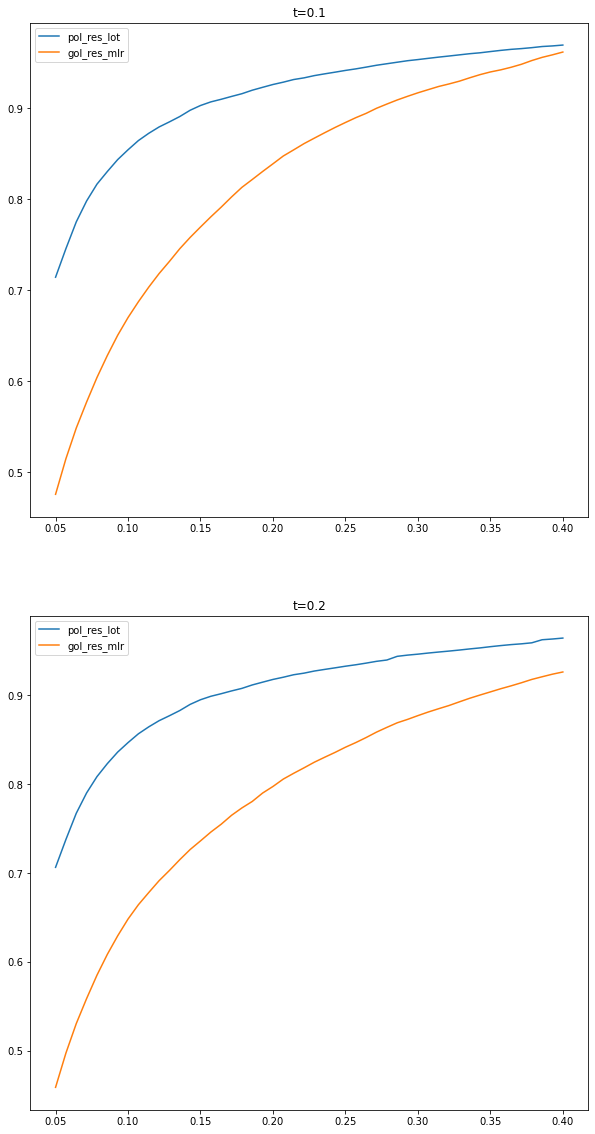

In [5]:
from timeit import default_timer as timer

fig, axes = plt.subplots(len(obj_thresholds), 1, squeeze=False)
fig.set_figheight(fig_size*len(obj_thresholds))
fig.set_figwidth(fig_size)

eval_time = 0
plot_time = 0
for i, obj_threshold in enumerate(obj_thresholds):
    for method in candidate_methods:
        print('Evaluating method {} with threshold {} ...'.format(method, obj_threshold))
        sol = load_solution(method, is_gt=False)
        
        t0 = timer()
        mso_eval = MSOEvaluation(witness=witness, inf_dist=inf_dist,
                                 obj_threshold=obj_threshold, 
                                precision_thresholds=precision_thresholds,
                                gt_solution=gt_sol,
                                candidate_solution=sol)
        mso_eval.eval()
        eval_time += timer() - t0
        print(mso_eval.avg_results)
        
        t0 = timer()
        axes[i, 0].plot(precision_thresholds, mso_eval.avg_results['precision'], label=method)
        axes[i, 0].legend()
        axes[i, 0].set_title('t={}'.format(obj_threshold))
        plot_time += timer() - t0
print('eval time: {}, plot time: {}'.format(eval_time, plot_time))

In [6]:
print(gt_sol.X.shape)

torch.Size([256, 1024, 2])
